# **CUSTOMER CHURN PREDICTION CAHLLENGE FOR AZUBIAN**

In this project, we aim to find the likelihood of a customer leaving the service,  
the key indicators of churn as well as the retention strategies that can be implemented to avert this problem.

`Null hypothesis`
- Customer churn depends on the period of time a customer has been with the company.

`Alternate hypothesis`
- Customer churn does not depend on the period of time the customer has been with the company.

`Business Questions`
1. ⁠What is the churn rate among customers?
2. What is the churn rate across the regions?
3. What is the call disribution across networks(ON_NET, ORANGE and TIGO)
4. What is the churn rate based on customer regularity
5. What is the churn rate based on the number of times the client has activated the top pack packages

## NECESSARY IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FunctionTransformer
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.preprocessing import quantile_transform, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import catboost as cb
from sklearn.neural_network import MLPClassifier
import pickle
import warnings

warnings.filterwarnings("ignore")


## DATA COLLECTION

In [2]:
train = pd.read_csv('Data/Train.csv')

train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,7ee9e11e342e27c70455960acc80d3f91c1286d1,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,185.0,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,30.0,0
1,50443f42bdc92b10388fc56e520e4421a5fa655c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
2,da90b5c1a9b204c186079f89969aa01cb03c91b2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
3,364ec1b424cdc64c25441a444a16930289a0051e,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,20.0,NaN,2.0,NO,61,"Data:490F=1GB,7d",7.0,0
4,d5a5247005bc6d41d3d99f4ef312ebb5f640f2cb,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,34.0,NaN,NaN,NO,56,All-net 500F=2000F;5d,11.0,0


In [3]:
test = pd.read_csv('Data/Test.csv')

test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,MATAM,I 18-21 month,2500.0,5.0,2500.0,833.0,5.0,0.0,64.0,70.0,NaN,NaN,NaN,NO,35,All-net 500F=2000F;5d,5.0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN
2,5a4db591c953a8d8f373877fad37aaf4268899a1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NO,22,NaN,NaN
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,SAINT-LOUIS,K > 24 month,5100.0,7.0,5637.0,1879.0,15.0,7783.0,30.0,24.0,0.0,0.0,NaN,NO,60,"Data:1000F=2GB,30d",4.0


In [4]:
train.shape, test.shape

((1077024, 19), (190063, 18))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1077024 non-null  object 
 1   REGION          652687 non-null   object 
 2   TENURE          1077024 non-null  object 
 3   MONTANT         699139 non-null   float64
 4   FREQUENCE_RECH  699139 non-null   float64
 5   REVENUE         714669 non-null   float64
 6   ARPU_SEGMENT    714669 non-null   float64
 7   FREQUENCE       714669 non-null   float64
 8   DATA_VOLUME     547261 non-null   float64
 9   ON_NET          683850 non-null   float64
 10  ORANGE          629880 non-null   float64
 11  TIGO            432250 non-null   float64
 12  ZONE1           84898 non-null    float64
 13  ZONE2           68794 non-null    float64
 14  MRG             1077024 non-null  object 
 15  REGULARITY      1077024 non-null  int64  
 16  TOP_PACK        626129 non-null   ob

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190063 entries, 0 to 190062
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         190063 non-null  object 
 1   REGION          115330 non-null  object 
 2   TENURE          190063 non-null  object 
 3   MONTANT         123695 non-null  float64
 4   FREQUENCE_RECH  123695 non-null  float64
 5   REVENUE         126422 non-null  float64
 6   ARPU_SEGMENT    126422 non-null  float64
 7   FREQUENCE       126422 non-null  float64
 8   DATA_VOLUME     96716 non-null   float64
 9   ON_NET          120771 non-null  float64
 10  ORANGE          111417 non-null  float64
 11  TIGO            76555 non-null   float64
 12  ZONE1           14850 non-null   float64
 13  ZONE2           12011 non-null   float64
 14  MRG             190063 non-null  object 
 15  REGULARITY      190063 non-null  int64  
 16  TOP_PACK        110773 non-null  object 
 17  FREQ_TOP_P

## DATA CLEANING

In [7]:
train.isnull().sum()

user_id                 0
REGION             424337
TENURE                  0
MONTANT            377885
FREQUENCE_RECH     377885
REVENUE            362355
ARPU_SEGMENT       362355
FREQUENCE          362355
DATA_VOLUME        529763
ON_NET             393174
ORANGE             447144
TIGO               644774
ZONE1              992126
ZONE2             1008230
MRG                     0
REGULARITY              0
TOP_PACK           450895
FREQ_TOP_PACK      450895
CHURN                   0
dtype: int64

In [8]:
test.isnull().sum()

user_id                0
REGION             74733
TENURE                 0
MONTANT            66368
FREQUENCE_RECH     66368
REVENUE            63641
ARPU_SEGMENT       63641
FREQUENCE          63641
DATA_VOLUME        93347
ON_NET             69292
ORANGE             78646
TIGO              113508
ZONE1             175213
ZONE2             178052
MRG                    0
REGULARITY             0
TOP_PACK           79290
FREQ_TOP_PACK      79290
dtype: int64

In [9]:
def clean_data(df):
    """ Data Cleaning Fuction"""
    # 1. Handling Missing Values
    # Dropping columns with a significant percentage of missing values (e.g., ZONE1, ZONE2)
    df = df.drop(columns=['ZONE1', 'ZONE2'], errors='ignore')

    # Filling missing values for numeric columns using median
    for col in ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'FREQ_TOP_PACK']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # For categorical columns, filling missing values with a placeholder
    df['REGION'] = df['REGION'].fillna('Unknown') if 'REGION' in df.columns else df['REGION']
    df['TOP_PACK'] = df['TOP_PACK'].fillna('None') if 'TOP_PACK' in df.columns else df['TOP_PACK']


    # 2. Correcting Data Types
    # Ensuring CHURN is integer and user_id is treated as object if they exist
    if 'CHURN' in df.columns:
        df['CHURN'] = df['CHURN'].astype(int)

    df['user_id'] = df['user_id'].astype(str)

    # Converting MRG and TENURE to categorical if they exist
    df['MRG'] = df['MRG'].astype('category') if 'MRG' in df.columns else df['MRG']
    df['TENURE'] = df['TENURE'].astype('category') if 'TENURE' in df.columns else df['TENURE']


    # 3. Droping duplicates based on 'user_id' if they exist
    if 'user_id' in df.columns:
        df = df.drop_duplicates(subset=['user_id'])

    return df


# Cleaning both train and test dataframes
train = clean_data(train)
test = clean_data(test)

# Optionally save the cleaned datasets to new CSV files
train.to_csv('Data/cleaned_train_data.csv', index=False)
test.to_csv('Data/cleaned_test_data.csv', index=False)

In [10]:
# checking for null values
train.isnull().sum()

user_id           0
REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
MRG               0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
CHURN             0
dtype: int64

In [11]:
# checking for null values
test.isnull().sum()

user_id           0
REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
MRG               0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
dtype: int64

## EXPLORATORY DATA ANALYSIS

### 1. Churn Distribution

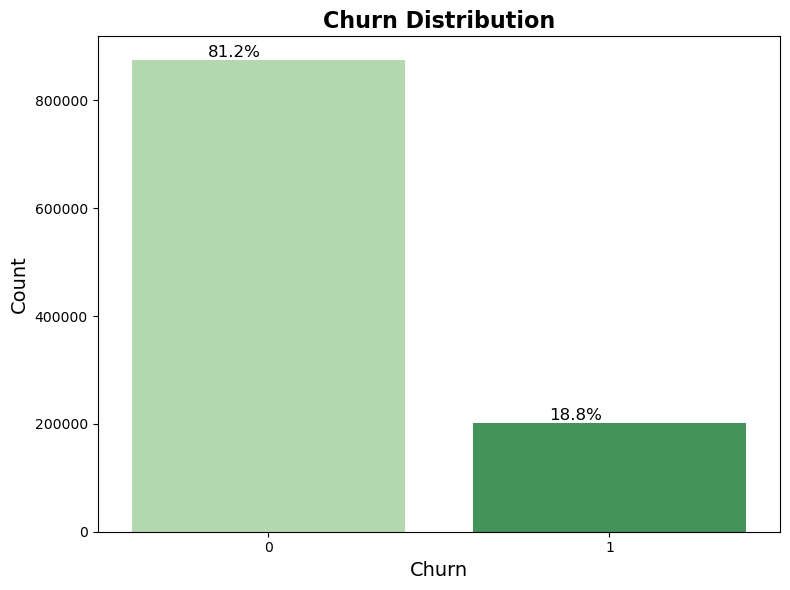

In [12]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CHURN', data=train, palette='Greens')
plt.title('Churn Distribution', fontsize=16, weight='bold')
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.grid(False)
total = len(train)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize=12, color='black', ha='center', va='bottom')
plt.tight_layout()
plt.show()



1. **Imbalance in Churn vs Non-Churn:**
- The majority of customers (`81.2%`) have not churned, meaning they are still active users (Churn = `0`).
- Only `18.8%` of customers have churned (Churn = `1`), indicating that while churn is present, it affects less than a fifth of the customer base.
- This presents a skewed or imbalanced distribution in churn behavior, with the vast majority of users staying engaged.

2. **Impact on Predictive Modeling:**
- The high imbalance in the target variable (churn) suggests that predictive models might face challenges due to class imbalance. Models trained on this data could be biased towards predicting non-churn outcomes due to the overwhelming presence of non-churn data points.

3. **Business Insights and Action Items:**
- With a churn rate of `18.8%`, the overall customer retention seems relatively strong. However, the presence of nearly `19%` churn is not negligible and calls for action to further reduce this rate.

### 2. Tenure Distribution

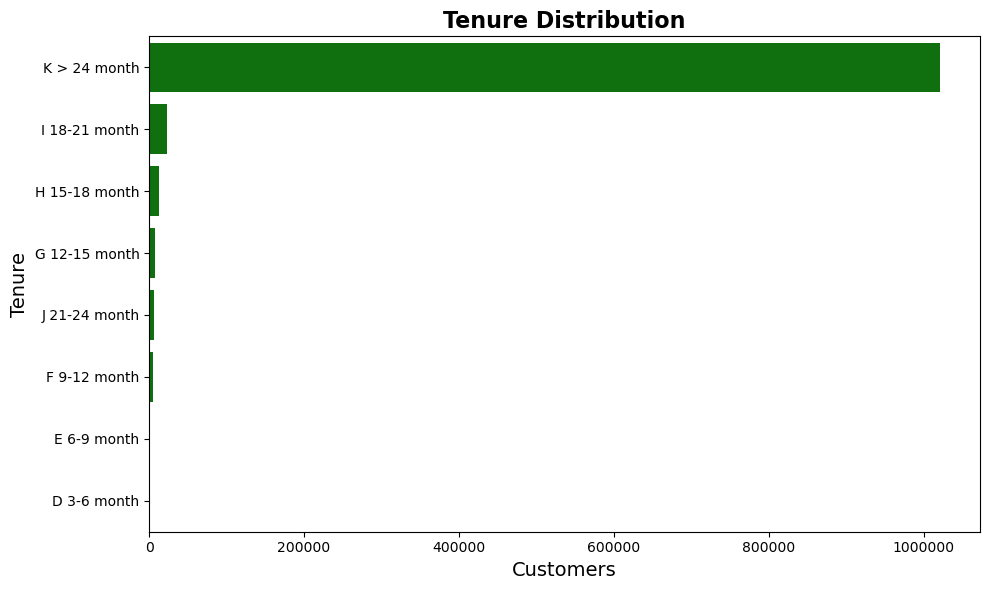

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='TENURE', data=train, order=train['TENURE'].value_counts().index, color='green')
plt.title('Tenure Distribution', fontsize=16, weight='bold')
plt.xlabel('Customers', fontsize=14)
plt.ylabel('Tenure', fontsize=14)
ax.grid(False)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
plt.tight_layout()
plt.show()


1. **Majority of Customers with Tenure Greater Than 24 Months:**
- The chart shows that the overwhelming majority of customers (classified as "`K > 24 months`") have been with the company for over `24 months`. This is by far the largest group, indicating that many customers are long-term users.
- This could reflect strong customer loyalty or satisfaction among a significant portion of the customer base.

2. **Minor Representation in Other Tenure Categories:**
- Customers with shorter tenure durations (from `3 to 24 months`) represent a much smaller portion of the overall customer base.
- These shorter-tenure groups ("I 18-21 months", "H 15-18 months", "G 12-15 months", etc.) have significantly fewer customers when compared to the group with over 24 months of tenure.

3. **Potential Impact on Churn:**
- The fact that a majority of customers have a tenure of more than `24 months` might suggest that once customers pass a certain tenure threshold, they are less likely to churn.
- Conversely, customers in the shorter-tenure categories could be more at risk of churning. These shorter-term customers may require more attention and targeted strategies to increase their likelihood of remaining loyal.

4. **Actionable Business Insights:**
- **Focus on Short-Tenure Customers**: The small number of customers in the lower tenure categories suggests that a significant portion of new customers may not be making it to long-term status. Investigating the reasons why shorter-term customers churn early could provide opportunities to improve retention strategies.
- **Retention Strategies for Long-Term Customers**: While long-term customers appear to be satisfied, it's important to continue nurturing this group to ensure they remain loyal. Offering loyalty rewards, exclusive services, or discounts for these customers could help maintain high retention rates.

### 3. Revenue vs Churn

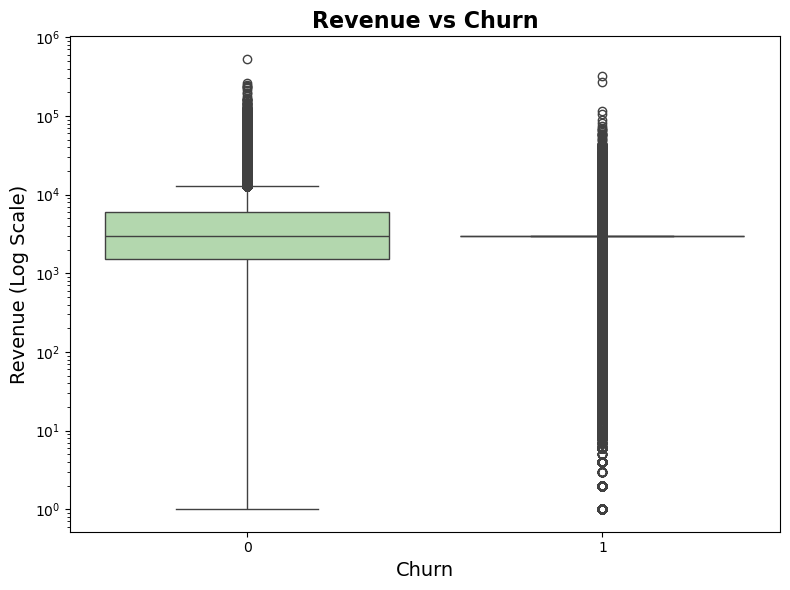

In [14]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='CHURN', y='REVENUE', data=train, palette='Greens')
ax.set_yscale('log')
plt.title('Revenue vs Churn', fontsize=16, weight='bold')
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Revenue (Log Scale)', fontsize=14)
ax.grid(False)
plt.tight_layout()
plt.show()

1. **Revenue Distribution for Non-Churners (Churn = 0):**
- The revenue distribution for non-churners is concentrated between approximately `100` and `10,000` (on the logarithmic scale), with the median revenue value being around the `1,000` mark.
- There are several high-revenue outliers, where a small number of non-churning customers generate significantly more revenue (above `10,000` and even approaching `100,000`).
- This suggests that non-churning customers tend to generate relatively higher and more consistent revenue.

2. **Revenue Distribution for Churners (Churn = 1):**
- The revenue for churners shows a different pattern, with the majority of churners generating lower revenue. The box plot indicates that a large portion of churners has revenue close to the lower end of the scale (around `10` to `1,000`), and very few high-revenue customers exist among the churners.
- There are some outliers, but overall, churners seem to generate significantly less revenue compared to non-churners.


**Actionable Insights:**
- **Retention Focus on High-Revenue Customers**: High-revenue customers are crucial for business profitability. Implementing customer retention strategies such as personalized offers, loyalty programs, or VIP customer support could help ensure these valuable customers remain engaged.
- **Analyze Low Revenue Churners**: Understanding why low-revenue customers churn can help identify service improvements, pricing adjustments, or targeted marketing efforts that could help turn these customers into higher-revenue, loyal users. For example, these customers may need different types of plans or service tiers to meet their needs and encourage continued usage.


### 4. Correlation Heatmap

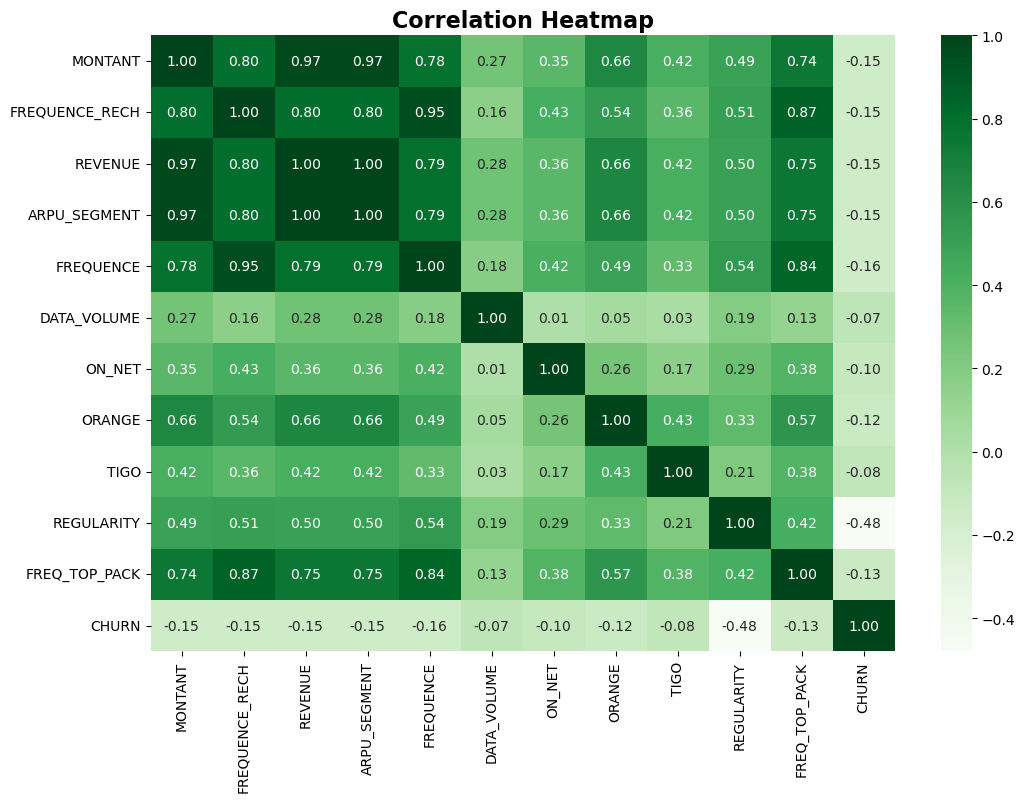

In [15]:

numeric_data = train.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='Greens', fmt='.2f')
plt.title('Correlation Heatmap', fontsize=16, weight='bold')
plt.show()


1. **Churn and Other Variables:**
- **Regularity (-0.48)**: There is a moderate negative correlation between churn and regularity. This suggests that customers who are more regular in their usage are less likely to churn.
- **Other Features**: Variables such as **MONTANT**, **FREQUENCE_RECH**, **REVENUE**, and **ARPU_SEGMENT** have weak negative correlations with churn (`-0.15` to `-0.16`). This indicates that these variables may have a small effect on churn, but the relationship is not strong.

**2. High Positive Correlations Between Variables:**
- **MONTANT, REVENUE, and ARPU_SEGMENT**: These features show very high positive correlations with each other, all around `0.97` to `1.00`. This means that these variables are likely closely related to the monetary aspects of customer behavior, such as spending and revenue generation.
- **FREQUENCE and FREQUENCE_RECH**: There is a very high positive correlation (`0.95`) between frequency of recharges and frequency of general usage, suggesting that more frequent users tend to recharge more often.
- **FREQ_TOP_PACK and FREQUENCE**: A strong positive correlation (0.84) suggests that customers who frequently use top packs tend to have higher overall usage.

### 3. Weak Correlations:
- **DATA_VOLUME (`-0.07`)**: Data volume has a very weak correlation with churn, indicating that the amount of data used is not a significant predictor of whether a customer will churn.
- **ON_NET, ORANGE, TIGO**: These features related to different network services (on-net usage, and usage on other networks like Orange and Tigo) have weak to moderate correlations with churn, ranging from `-0.08` to `-0.12`.

### 4. Key Variables for Churn Prediction:
- **Regularity** stands out as the most significant predictor of churn, with a moderate negative correlation. Customers with regular patterns of engagement appear less likely to churn.
- The other variables (monetary and usage-based) show weaker relationships with churn, but they still provide some insights into customer behavior and potential risks for churn.

### 5. Region Distribution

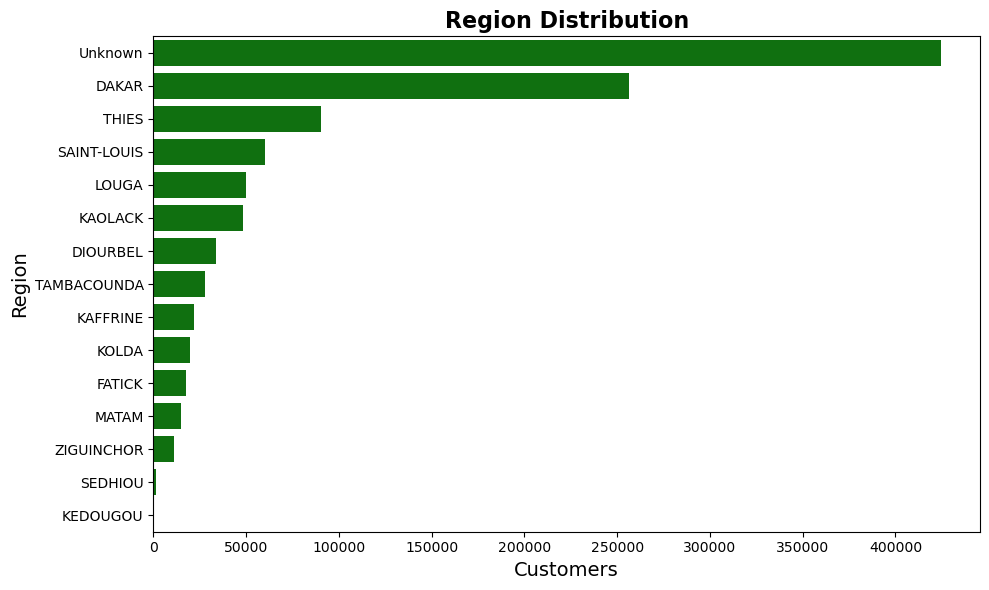

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='REGION', data=train, order=train['REGION'].value_counts().index, color='green')
plt.title('Region Distribution', fontsize=16, weight='bold')
plt.xlabel('Customers', fontsize=14)
plt.ylabel('Region', fontsize=14)
ax.grid(False)
plt.tight_layout()
plt.show()

### 6. Revenue and Frequency Distribution

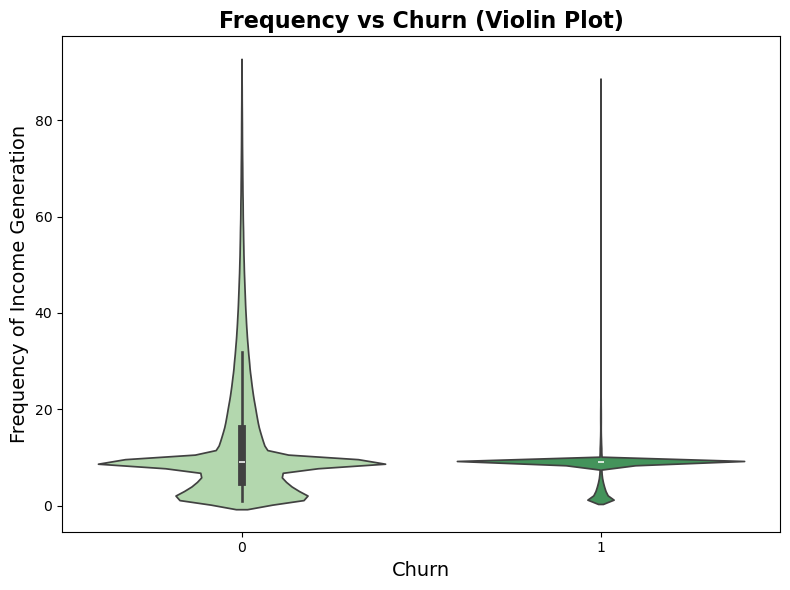

In [17]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='CHURN', y='FREQUENCE', data=train, palette='Greens')
plt.title('Frequency vs Churn (Violin Plot)', fontsize=16, weight='bold')
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Frequency of Income Generation', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


In [18]:
top_pack_table = train['TOP_PACK'].value_counts(normalize=False).head(20).reset_index()
top_pack_table.columns = ['TOP_PACK', 'Counts']
top_pack_table['Proportion'] = train['TOP_PACK'].value_counts(normalize=True).head(20).values
top_pack_table

,TOP_PACK,Counts,Proportion
0,None,450895,0.418649
1,All-net 500F=2000F;5d,158779,0.147424
2,On net 200F=Unlimited _call24H,76302,0.070845
3,"Data:490F=1GB,7d",57679,0.053554
4,"Data: 100 F=40MB,24H",42515,0.039475
5,Mixt 250F=Unlimited_call24H,33620,0.031216
6,MIXT:500F= 2500F on net _2500F off net;2d,32164,0.029864
7,"Data:1000F=2GB,30d",29982,0.027838
8,All-net 500F =2000F_AllNet_Unlimited,23476,0.021797
9,Jokko_Daily,22548,0.020935


In [19]:
summary_statistics = train.select_dtypes(include=['int64', 'float64']).describe().T
summary_statistics

,count,mean,std,min,25%,50%,75%,max
MONTANT,1077024.0,4641.811117,5850.106520,20.0,2000.0,3000.0,4600.0,470000.0
FREQUENCE_RECH,1077024.0,9.936549,10.900959,1.0,4.0,7.0,10.0,131.0
REVENUE,1077024.0,4662.912635,5963.927860,1.0,1900.0,3000.0,4700.0,532177.0
ARPU_SEGMENT,1077024.0,1554.307990,1987.973213,0.0,633.0,1000.0,1567.0,177392.0
FREQUENCE,1077024.0,12.300834,12.192635,1.0,6.0,9.0,13.0,91.0
DATA_VOLUME,1077024.0,1838.670868,9325.304670,0.0,232.0,258.0,293.0,1702309.0
ON_NET,1077024.0,185.777795,707.009825,0.0,12.0,27.0,55.0,50809.0
ORANGE,1077024.0,67.693072,158.644324,0.0,20.0,29.0,41.0,12040.0
TIGO,1077024.0,12.864883,41.424575,0.0,6.0,6.0,6.0,4174.0
REGULARITY,1077024.0,28.044496,22.288610,1.0,6.0,24.0,51.0,62.0


## HYPOTHESIS TESTING

In [20]:
# Creating contingency table
contingency_table = pd.crosstab(train['TENURE'], train['CHURN'])

# chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
 
chi2, p, dof, expected

(2898.5207691813353,
 0.0,
 7,
 array([[3.14419175e+02, 7.25808255e+01],
        [7.54768509e+02, 1.74231491e+02],
        [3.74053199e+03, 8.63468012e+02],
        [6.10964391e+03, 1.41035609e+03],
        [1.04912010e+04, 2.42179897e+03],
        [1.82753098e+04, 4.21869015e+03],
        [5.13795054e+03, 1.18604946e+03],
        [8.30207175e+05, 1.91645825e+05]]))

In [21]:
alpha = 0.05
if p < alpha:
    result = "We Reject the Null Hypothesis (H2): Customer churn depends on the period of time a customer has been with the company."
else:
    result = "We Fail to Reject the Null Hypothesis (H2'): Customer churn does not depend on the period of time a customer has been with the company."
result

'We Reject the Null Hypothesis (H2): Customer churn depends on the period of time a customer has been with the company.'

## ANSWERING ANALIYTICAL QUESTIONS

### 1. ⁠What is the churn rate among customers?

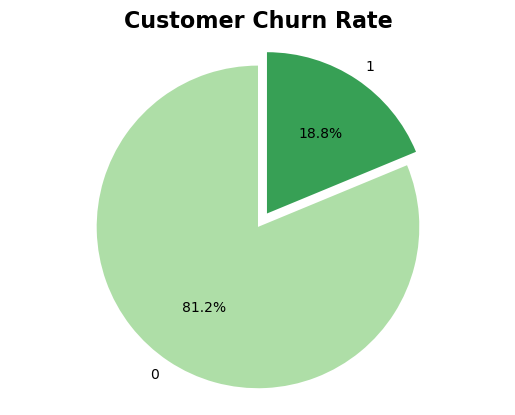

In [22]:
churn_rate = train['CHURN'].value_counts(normalize=True)[1] * 100

sns.set_palette('coolwarm')
churn_counts = train['CHURN'].value_counts()

plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('Greens', 2), explode=(0.1, 0))
plt.title('Customer Churn Rate', fontsize=16, weight='bold')
plt.axis('equal') 
plt.show()

### 2. What is the churn rate across the regions?

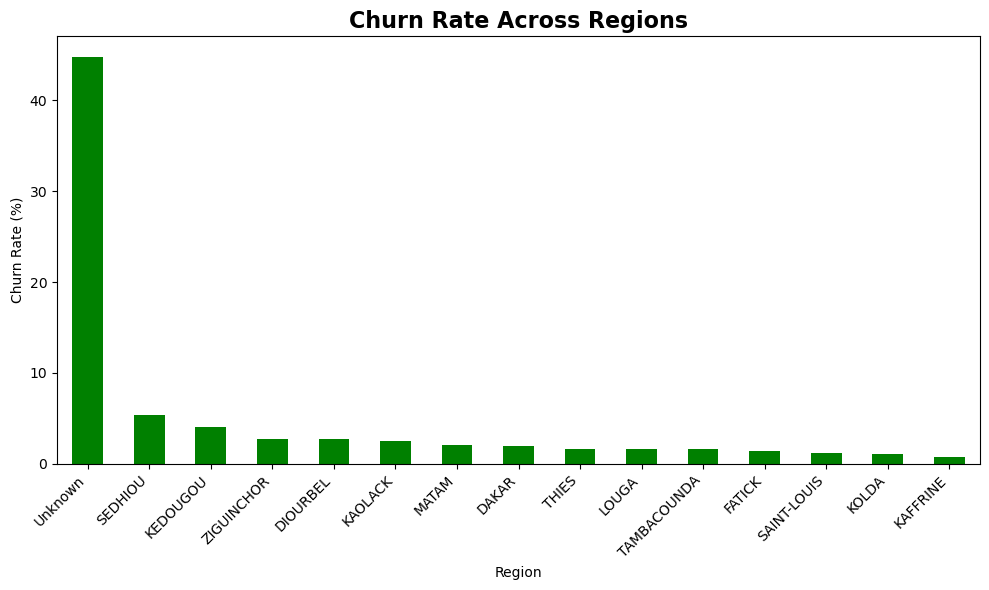

In [23]:
churn_rate_by_region = train.groupby('REGION')['CHURN'].mean() * 100  
churn_rate_by_region_sorted = churn_rate_by_region.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
churn_rate_by_region_sorted.plot(kind='bar', color='green')
plt.title('Churn Rate Across Regions', fontsize=16, weight='bold')
plt.xlabel('Region')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 3. What is the call disribution across networks(ON_NET, ORANGE and TIGO)

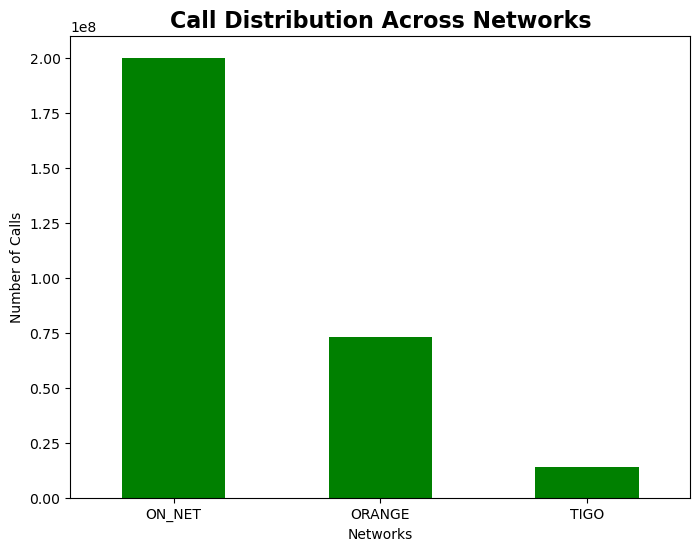

In [24]:
call_columns = ['ON_NET', 'ORANGE', 'TIGO']
call_distribution = train[call_columns].sum()

plt.figure(figsize=(8, 6))
call_distribution.plot(kind='bar', color='green')
plt.title('Call Distribution Across Networks', fontsize=16, weight='bold')
plt.xlabel('Networks')
plt.ylabel('Number of Calls')
plt.xticks(rotation=0)
plt.show()

### 4. What is the churn rate based on customer regularity

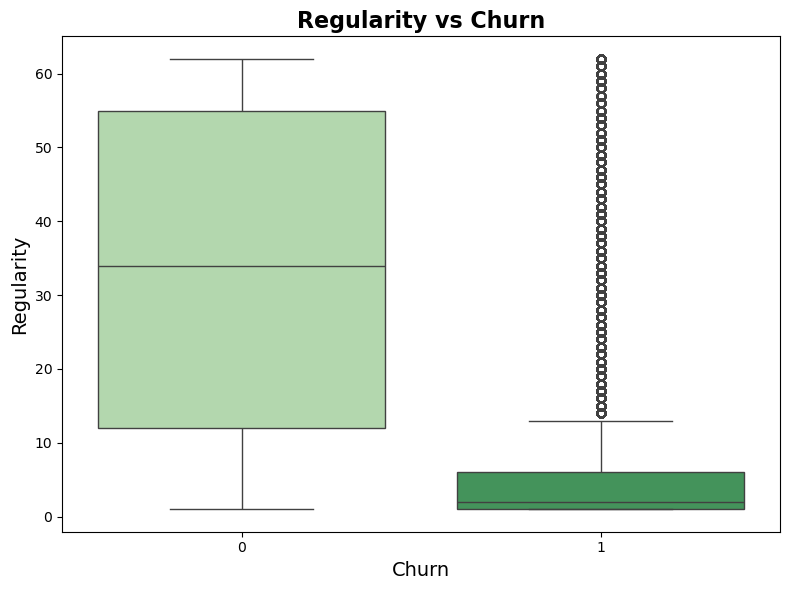

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='CHURN', y='REGULARITY', data=train, palette='Greens')
plt.title('Regularity vs Churn', fontsize=16, weight='bold')
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Regularity', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

### 5. What is the churn rate based on the number of times the client has activated the top pack packages

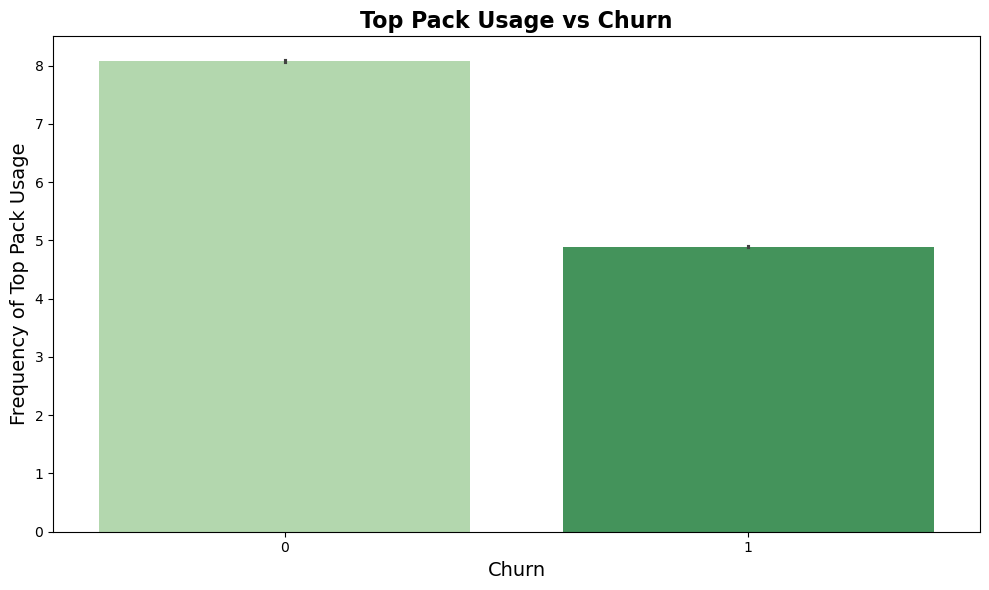

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='CHURN', y='FREQ_TOP_PACK', data=train, palette='Greens')
plt.title('Top Pack Usage vs Churn', fontsize=16, weight='bold')
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Frequency of Top Pack Usage', fontsize=14)
ax.grid(False)
plt.tight_layout()
plt.show()

##  DATA PREPROCESSING

In [27]:
# Dropping user_id column
train.drop(columns=['user_id'], axis=1, inplace=True)

In [28]:
# Identifying features and target variable
X = train.drop(columns=['CHURN'])
y = train['CHURN']

In [29]:
# Separating numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [30]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('quantile_transform', FunctionTransformer(func=quantile_transform, validate=False)),
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])

# Applying preprocessing to the data
X = preprocessor.fit_transform(X)

In [31]:
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X, y)


In [32]:
# Separating the data into x_train and y_train
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

## Modeling

In [33]:
# Defining the models
models = {
    'random_forest': RandomForestClassifier(random_state=42),
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
    'knn': KNeighborsClassifier(),
    'gradient_boosting': GradientBoostingClassifier(random_state=42),
    'xgboost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    'lightgbm': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'catboost': cb.CatBoostClassifier(random_state=42, verbose=0),
    'mlp': MLPClassifier(random_state=42, max_iter=1000),
    'adaboost': AdaBoostClassifier(random_state=42)
}

In [34]:
# Initializing KFold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
# Model Selection with HalvingGridSearchCV 
grid_searches = {}
for model_name, model in models.items():
    pipeline = Pipeline(
        steps=[
               ('model', model)
               ])

    # Halving Grid Search with Automatic Resource Detection
    grid_search = HalvingGridSearchCV(pipeline, {}, cv=kf, factor=2, scoring='accuracy', n_jobs=2)


    # Fitting the model
    grid_search.fit(X_train, y_train)
    grid_searches[model_name] = grid_search

/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:23:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:23:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:23:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:23:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:23:2

In [36]:
# Initializing a dictionary to hold evaluation metrics
evaluation_results = {}

# Evaluating each model on the validation set
for model_name, grid_search in grid_searches.items():
    y_pred = grid_search.predict(X_val)
    y_pred_proba = grid_search.predict_proba(X_val)[:, 1] if hasattr(
        grid_search.best_estimator_, "predict_proba") else None

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None

    evaluation_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix,
        'auc': auc
    }

df_scores = pd.DataFrame(evaluation_results).transpose()
df_scores_sorted = df_scores.sort_values(by="auc", ascending=False)
df_scores_sorted = df_scores_sorted.drop(columns=['confusion_matrix'])

print("Model Evaluation Scores:")
df_scores_sorted

Model Evaluation Scores:


,accuracy,precision,recall,auc
lightgbm,0.866717,0.832145,0.91876,0.930574
xgboost,0.867262,0.83139,0.921384,0.930218
catboost,0.866643,0.83257,0.917869,0.930171
gradient_boosting,0.8659,0.834843,0.912275,0.930067
mlp,0.865133,0.829455,0.91928,0.929403
logistic_regression,0.862831,0.836532,0.901904,0.92877
adaboost,0.860021,0.840007,0.889453,0.928431
random_forest,0.85986,0.833043,0.900121,0.923487
knn,0.84939,0.826827,0.883908,0.895031


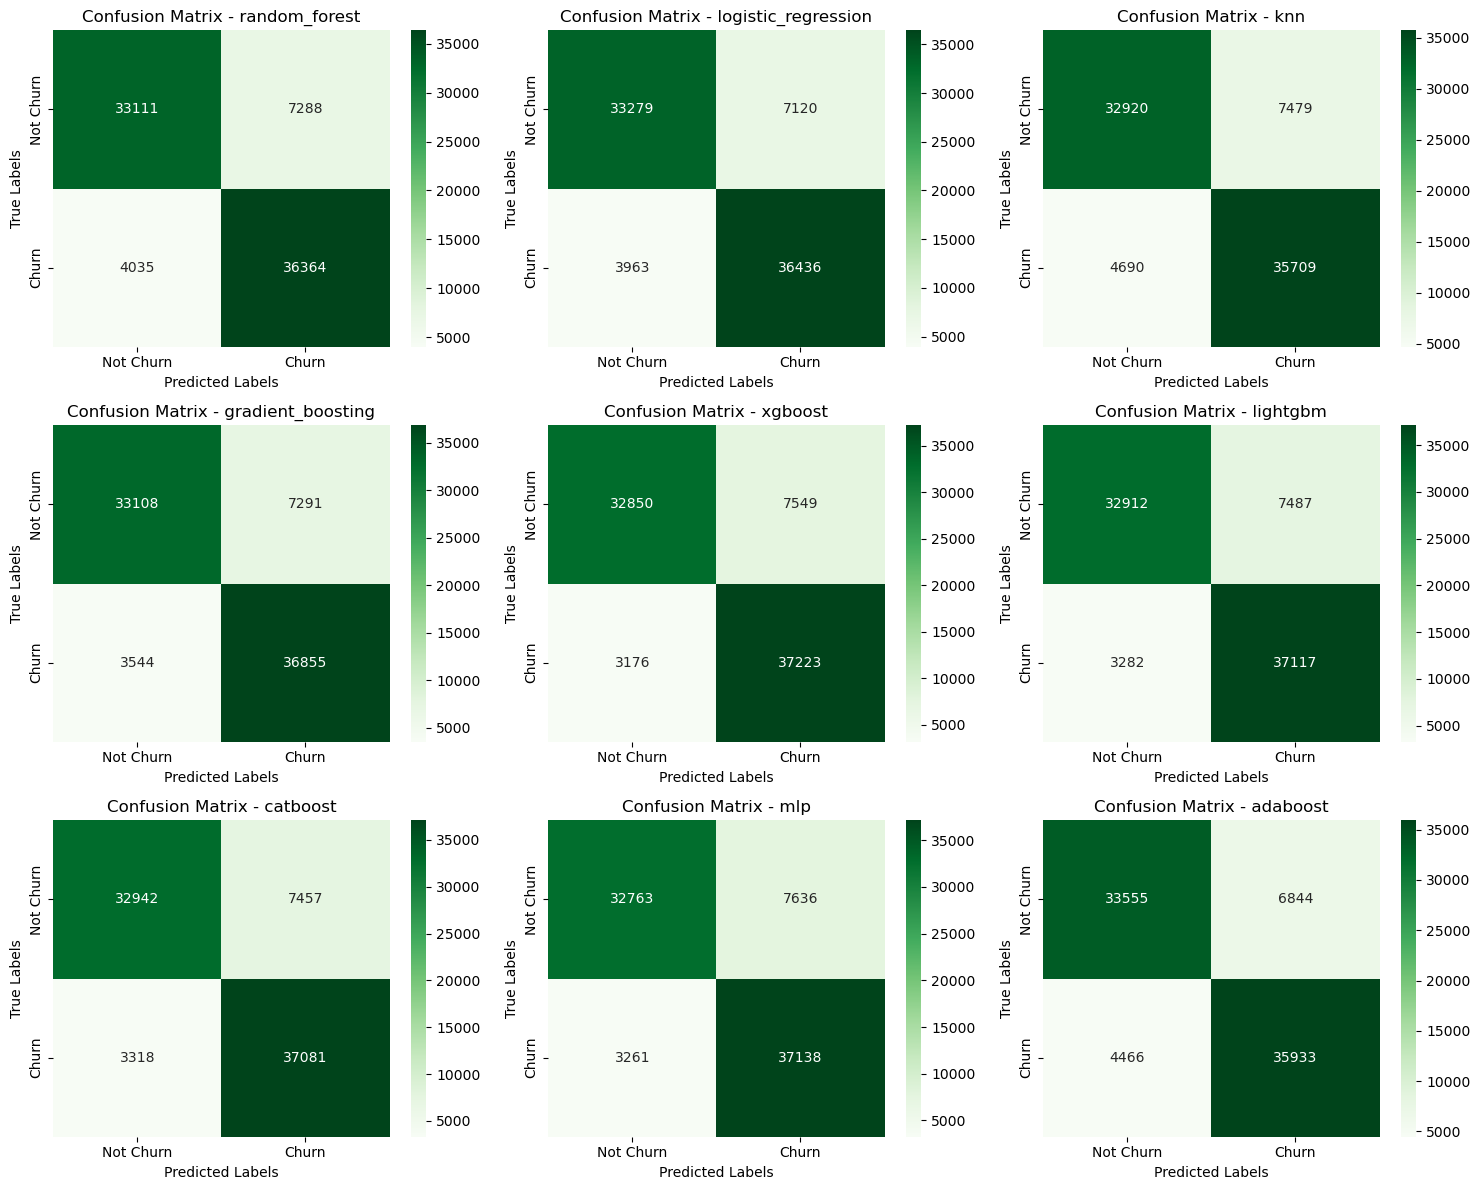

In [37]:
def plot_confusion_matrices(df_scores, figsize=(15, 12), ncols=3):
    nrows = int(np.ceil(len(df_scores) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for i, (model_name, row) in enumerate(df_scores.iterrows()):
        conf_matrix = row['confusion_matrix']
        ax = axes.flat[i]
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens',
                    xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=ax)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(f'Confusion Matrix - {model_name}')

    # Hide any unused subplots
    for i in range(len(df_scores), nrows * ncols):
        fig.delaxes(axes.flat[i])

    if nrows > 1 and ncols > 1:
        plt.tight_layout()
    plt.show()

plot_confusion_matrices(df_scores)

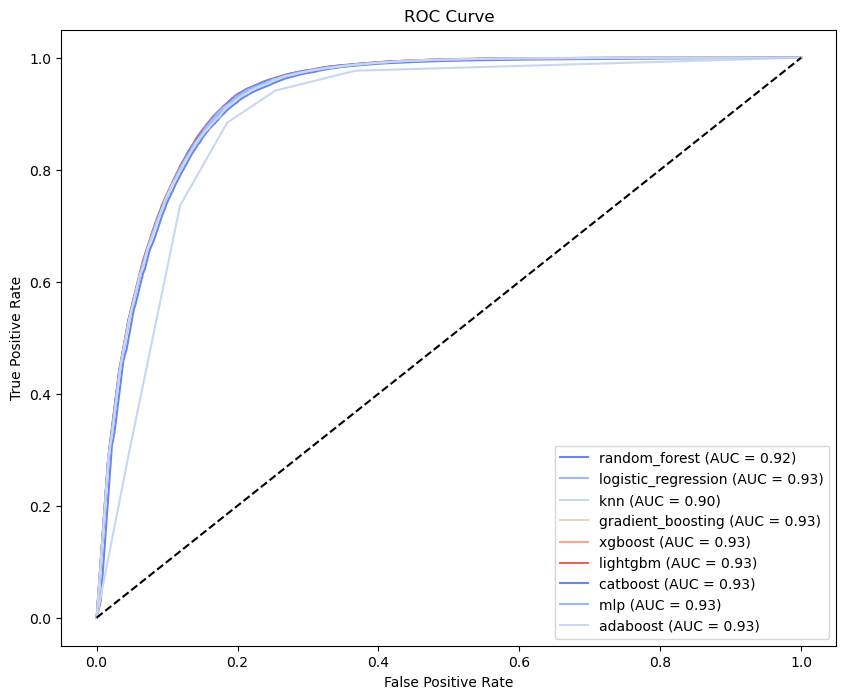

In [38]:
# ROC curve for each model
plt.figure(figsize=(10, 8))
for model_name, grid_search in grid_searches.items():
    if evaluation_results[model_name]['auc'] is not None:
        fpr, tpr, _ = roc_curve(y_val, grid_search.predict_proba(X_val)[:, 1])
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {
                 evaluation_results[model_name]['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Hyperparameter Tuning

In [40]:
# Defining the best models
best_models = {
    'lightgbm': lgb.LGBMClassifier(random_state=42, objective='binary', verbose=-1),
    'xgboost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Defining the tuned parameter grid for each model
param_grid = {
    'lightgbm': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__num_leaves': [31, 63, 127]
    },
    'xgboost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

In [41]:
tuned_grid_searches = {}

for best_model_name, model in best_models.items():
    pipeline = Pipeline(steps=[('model', model)])
    tuned_grid_search = GridSearchCV(
        pipeline, param_grid[best_model_name], cv=5, n_jobs=-1, scoring='roc_auc')

    tuned_grid_search.fit(X_train, y_train)
    tuned_grid_searches[best_model_name] = tuned_grid_search

/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:07:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:07:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:07:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:07:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/egovridc/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:07:5

In [42]:
# Initializing a dictionary to hold tuned evaluation metrics
tuned_evaluation_results = {}

# Evaluating each model on the validation set
for best_model_name, tuned_grid_search in tuned_grid_searches.items():
    y_pred = tuned_grid_search.predict(X_val)
    y_pred_proba = tuned_grid_search.predict_proba(X_val)[:, 1] if hasattr(
        tuned_grid_search.best_estimator_, "predict_proba") else None

    tuned_accuracy = accuracy_score(y_val, y_pred)
    tuned_precision = precision_score(y_val, y_pred, average='binary')
    tuned_recall = recall_score(y_val, y_pred, average='binary')
    tuned_conf_matrix = confusion_matrix(y_val, y_pred)
    tuned_auc = roc_auc_score(
        y_val, y_pred_proba) if y_pred_proba is not None else None

    tuned_evaluation_results[best_model_name] = {
        'accuracy': tuned_accuracy,
        'precision': tuned_precision,
        'recall': tuned_recall,
        'confusion_matrix': tuned_conf_matrix,
        'auc': tuned_auc
    }

tuned_df_scores = pd.DataFrame(tuned_evaluation_results).transpose()
tuned_df_scores_sorted = tuned_df_scores.sort_values(by="accuracy", ascending=False)
tuned_df_scores_sorted = tuned_df_scores_sorted.drop(columns=['confusion_matrix'])

print("Model Evaluation Scores:")
tuned_df_scores_sorted

Model Evaluation Scores:


,accuracy,precision,recall,auc
xgboost,0.866927,0.83303,0.91782,0.930577
lightgbm,0.866779,0.831837,0.919429,0.930502


In [43]:
for model_name, grid_search in tuned_grid_searches.items():
    print(f"Best AUC for {model_name}: {grid_search.best_score_}")
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

Best AUC for lightgbm: 0.9308040444844444
Best parameters for lightgbm: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 50, 'model__num_leaves': 63}
Best AUC for xgboost: 0.9308029868439093
Best parameters for xgboost: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}


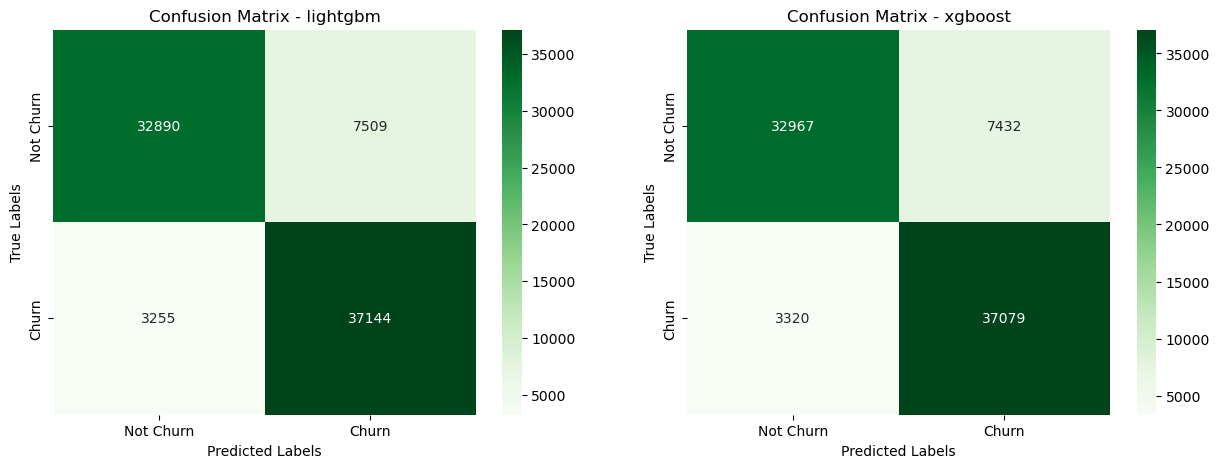

In [44]:
def plot_confusion_matrices(tuned_df_scores, figsize=(15, 5), ncols=2):
    nrows = int(np.ceil(len(tuned_df_scores) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for i, (best_model_name, row) in enumerate(tuned_df_scores.iterrows()):
        tuned_conf_matrix = row['confusion_matrix']
        ax = axes.flat[i]
        sns.heatmap(tuned_conf_matrix, annot=True, fmt="d", cmap='Greens',
                    xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=ax)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(f'Confusion Matrix - {best_model_name}')

    if nrows > 1 and ncols > 1:
        plt.tight_layout()
    plt.show()

plot_confusion_matrices(tuned_df_scores)

## Exporting Key Components

In [46]:
#Components to export
export_dict = {
    'preprocessing': {
        'preprocessor': preprocessor,
    },
    'tuned_models': tuned_grid_searches
}

with open('Model/churn_model_components.pkl', 'wb') as f:
    pickle.dump(export_dict, f)

## Test Prediction

In [47]:
# Loading the exported model components
with open('Model/churn_model_components.pkl', 'rb') as f:
    exported_dict = pickle.load(f)

# Extract the components from the loaded dictionary
preprocessor = exported_dict['preprocessing']['preprocessor']
models = exported_dict['tuned_models']

In [48]:
# Preprocess the test data respectively 
test_data_processed = preprocessor.transform(test)

In [49]:
# predicting target variable
y_pred = models['xgboost'].predict(test_data_processed)

y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [50]:
y_pred_series = pd.Series(y_pred)
y_pred_series.head()

0    0
1    1
2    1
3    1
4    0
dtype: int64

## Submission file

In [52]:
# submission_sample dataset
submission_sample = pd.read_csv('Data/SampleSubmission.csv')

submission_sample.head()

,user_id,CHURN
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,0
2,5a4db591c953a8d8f373877fad37aaf4268899a1,0
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,0
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,0


In [53]:
test_pred_df = test

test_pred_df['CHURN'] = y_pred_series
test_pred_df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,MATAM,I 18-21 month,2500.0,5.0,2500.0,833.0,5.0,0.0,64.0,70.0,6.0,NO,35,All-net 500F=2000F;5d,5.0,0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,Unknown,K > 24 month,3000.0,7.0,3000.0,1000.0,9.0,265.0,27.0,28.0,6.0,NO,2,None,5.0,1
2,5a4db591c953a8d8f373877fad37aaf4268899a1,Unknown,K > 24 month,3000.0,7.0,3000.0,1000.0,9.0,0.0,27.0,28.0,6.0,NO,22,None,5.0,1
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,Unknown,K > 24 month,3000.0,7.0,3000.0,1000.0,9.0,265.0,27.0,28.0,6.0,NO,6,None,5.0,1
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,SAINT-LOUIS,K > 24 month,5100.0,7.0,5637.0,1879.0,15.0,7783.0,30.0,24.0,0.0,NO,60,"Data:1000F=2GB,30d",4.0,0


In [54]:
submission_pred = test_pred_df[['user_id', 'CHURN']]

submission_pred.head()

,user_id,CHURN
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,1
2,5a4db591c953a8d8f373877fad37aaf4268899a1,1
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,1
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,0


In [55]:
submission_pred.to_csv('Data/Churn_prediction.csv')